All right reserved by #https://github.com/apache/incubator-mxnet/blob/master/docs/tutorials/onnx/fine_tuning_gluon.md

In [1]:
import json
import logging
import multiprocessing
import os
import tarfile

logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon, nd, autograd
from mxnet.gluon.data.vision.datasets import ImageFolderDataset
from mxnet.gluon.data import DataLoader
import mxnet.contrib.onnx as onnx_mxnet
import numpy as np

%matplotlib inline

In [28]:
image_folder = "images"
utils_file = "utils.py" # contain utils function to plot nice visualization
images = ['4.jpg', '2.jpg', '3.jpg']
base_url = "https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/onnx/{}?raw=true"


for image in images:
    mx.test_utils.download(base_url.format("{}/{}".format(image_folder, image)), fname=image,dirname=image_folder)
mx.test_utils.download(base_url.format(utils_file), fname=utils_file)

from utils import *

INFO:root:images/4.jpg exists, skipping download
INFO:root:images/2.jpg exists, skipping download
INFO:root:images/3.jpg exists, skipping download
INFO:root:utils.py exists, skipping download


A pretrained GoogleNet model is used in this experiment.
This model is trained on ImageNet from the ONNX model zoo. 
The model comes packaged in an archive tar.gz file containing an model.onnx model file.

In [3]:
base_url = "https://s3.amazonaws.com/download.onnx/models/opset_3/"
current_model = "bvlc_alexnet"
model_folder = "model"
archive_file = "{}.tar.gz".format(current_model)
archive_path = os.path.join(model_folder, archive_file)
url = "{}{}".format(base_url, archive_file)
onnx_path = os.path.join(model_folder, current_model, 'model.onnx')

# Download the zipped model
mx.test_utils.download(url, dirname = model_folder)

# Extract the model
if not os.path.isdir(os.path.join(model_folder, current_model)):
    print('Extracting {} in {}...'.format(archive_path, model_folder))
    tar = tarfile.open(archive_path, "r:gz")
    tar.extractall(model_folder)
    tar.close()
    print('Model extracted.')


INFO:root:model/bvlc_alexnet.tar.gz exists, skipping download


In [4]:
data_folder = "data"
dataset_name = "101_ObjectCategories"
archive_file = "{}.tar.gz".format(dataset_name)
archive_path = os.path.join(data_folder, archive_file)
data_url = "https://s3.us-east-2.amazonaws.com/mxnet-public/"

# if not os.path.isfile(archive_path):
#     mx.test_utils.download("{}{}".format(data_url, archive_file), dirname = data_folder)
#     print('Extracting {} in {}...'.format(archive_file, data_folder))
#     tar = tarfile.open(archive_path, "r:gz")
#     tar.extractall(data_folder)
#     tar.close()
#     print('Data extracted.')

In [5]:
training_path = "/home/murshed/phd/git_research/mldledge/mxnet/train_model_with_own_dataset_inceptionnet/data/101_ObjectCategories"
testing_path = "/home/murshed/phd/git_research/mldledge/mxnet/train_model_with_own_dataset_inceptionnet/data/101_ObjectCategories_test"

In [6]:
EDGE = 224
SIZE = (EDGE, EDGE)
BATCH_SIZE = 8
NUM_WORKERS = 18

In [7]:
def transform(image, label):
    resized = mx.image.resize_short(image, EDGE)
    cropped, crop_info = mx.image.center_crop(resized, SIZE)
    transposed = nd.transpose(cropped, (2,0,1))
    return transposed, label

In [8]:
dataset_train = ImageFolderDataset(root=training_path)
dataset_test = ImageFolderDataset(root=testing_path)

In [9]:
dataloader_train = DataLoader(dataset_train.transform(transform, lazy=False), batch_size=BATCH_SIZE, last_batch='rollover',
                              shuffle=True, num_workers=NUM_WORKERS)
dataloader_test = DataLoader(dataset_test.transform(transform, lazy=False), batch_size=BATCH_SIZE, last_batch='rollover',
                             shuffle=False, num_workers=NUM_WORKERS)
print("Train dataset: {} images, Test dataset: {} images".format(len(dataset_train), len(dataset_test)))

Train dataset: 844 images, Test dataset: 200 images


In [10]:
categories = dataset_train.synsets
NUM_CLASSES = len(categories)
BATCH_SIZE = 32

clean


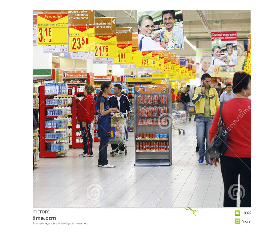

In [11]:
N = 100
plt.imshow((transform(dataset_train[N][0], 0)[0].asnumpy().transpose((1,2,0))))
plt.axis('off')
print(categories[dataset_train[N][1]])

In [12]:
sym, arg_params, aux_params = onnx_mxnet.import_model(onnx_path)
def get_layer_output(symbol, arg_params, aux_params, layer_name):
    all_layers = symbol.get_internals()
    net = all_layers[layer_name+'_output']
    net = mx.symbol.Flatten(data=net)
    new_args = dict({k:arg_params[k] for k in arg_params if k in net.list_arguments()})
    new_aux = dict({k:aux_params[k] for k in aux_params if k in net.list_arguments()})
    return (net, new_args, new_aux)

sym.get_internals()


<Symbol group [data_0, pad0, conv1_w_0, conv1_b_0, convolution0, relu0, lrn0, pad1, pooling0, pad2, conv2_w_0, conv2_b_0, convolution1, relu1, lrn1, pad3, pooling1, pad4, conv3_w_0, conv3_b_0, convolution2, relu2, pad5, conv4_w_0, conv4_b_0, convolution3, relu3, pad6, conv5_w_0, conv5_b_0, convolution4, relu4, pad7, pooling2, flatten0, fc6_w_0, linalg_gemm20, fc6_b_0, _mulscalar0, broadcast_add0, relu5, dropout0, flatten1, fc7_w_0, linalg_gemm21, fc7_b_0, _mulscalar1, broadcast_add1, relu6, dropout1, flatten2, fc8_w_0, linalg_gemm22, fc8_b_0, _mulscalar2, broadcast_add2, softmax0]>

In [13]:
new_sym, new_arg_params, new_aux_params = get_layer_output(sym, arg_params, aux_params, 'broadcast_add2')

In [14]:
ctx = mx.gpu() if mx.context.num_gpus() > 0 else mx.cpu()

In [15]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pre_trained = gluon.nn.SymbolBlock(outputs=new_sym, inputs=mx.sym.var('data_0'))
net_params = pre_trained.collect_params()
for param in new_arg_params:
    if param in net_params:
        net_params[param]._load_init(new_arg_params[param], ctx=ctx)
for param in new_aux_params:
    if param in net_params:
        net_params[param]._load_init(new_aux_params[param], ctx=ctx)

In [16]:
dense_layer = gluon.nn.Dense(NUM_CLASSES)
dense_layer.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

In [17]:
net = gluon.nn.HybridSequential()
net.hybridize()
with net.name_scope():
    net.add(pre_trained)
    net.add(dense_layer)

In [18]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [19]:
LEARNING_RATE = 0.0001
WDECAY = 0.00001
MOMENTUM = 0.9

In [20]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', 
                        {'learning_rate': LEARNING_RATE,
                         'wd':WDECAY,
                         'momentum':MOMENTUM})

In [21]:
def evaluate_accuracy_gluon(data_iterator, net):
    num_instance = 0
    sum_metric = nd.zeros(1,ctx=ctx, dtype=np.int32)
    for i, (data, label) in enumerate(data_iterator):
        data = data.astype(np.float32).as_in_context(ctx)
        label = label.astype(np.int32).as_in_context(ctx)
        output = net(data)
        prediction = nd.argmax(output, axis=1).astype(np.int32)
        num_instance += len(prediction)
        sum_metric += (prediction==label).sum()
    accuracy = (sum_metric.astype(np.float32)/num_instance)
    return accuracy.asscalar()


In [22]:
%%time
print("Untrained network Test Accuracy: {0:.4f}".format(evaluate_accuracy_gluon(dataloader_test, net)))

Untrained network Test Accuracy: 0.5550
CPU times: user 871 ms, sys: 198 ms, total: 1.07 s
Wall time: 344 ms


In [23]:
val_accuracy = 0
for epoch in range(5):
    for i, (data, label) in enumerate(dataloader_train):
        data = data.astype(np.float32).as_in_context(ctx)
        label = label.as_in_context(ctx)

        if i%20==0 and i >0:
            print('Batch [{0}] loss: {1:.4f}'.format(i, loss.mean().asscalar()))

        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])

    nd.waitall() # wait at the end of the epoch    
    new_val_accuracy = evaluate_accuracy_gluon(dataloader_test, net)    
    print("Epoch [{0}] Test Accuracy {1:.4f} ".format(epoch, new_val_accuracy))

#     # We perform early-stopping regularization, to prevent the model from overfitting
#     if val_accuracy > new_val_accuracy:
#         print('Validation accuracy is decreasing, stopping training')
#         break
    val_accuracy = new_val_accuracy

Batch [20] loss: 0.5984
Batch [40] loss: 0.8318
Batch [60] loss: 0.9929
Batch [80] loss: 0.9988
Batch [100] loss: 0.3368
Epoch [0] Test Accuracy 0.8100 
Batch [20] loss: 0.2907
Batch [40] loss: 0.0846
Batch [60] loss: 0.2853
Batch [80] loss: 0.2230
Batch [100] loss: 0.4772
Epoch [1] Test Accuracy 0.8950 
Batch [20] loss: 0.4028
Batch [40] loss: 0.3980
Batch [60] loss: 0.0654
Batch [80] loss: 0.1084
Batch [100] loss: 0.5066
Epoch [2] Test Accuracy 0.8650 
Batch [20] loss: 0.5524
Batch [40] loss: 0.1354
Batch [60] loss: 0.6183
Batch [80] loss: 0.3330
Batch [100] loss: 0.0888
Epoch [3] Test Accuracy 0.8950 
Batch [20] loss: 0.0990
Batch [40] loss: 0.0204
Batch [60] loss: 0.0735
Batch [80] loss: 0.3928
Batch [100] loss: 0.6252
Epoch [4] Test Accuracy 0.8350 


In [24]:
#Save net parameters
net.export(current_model, 100)
saved_model = current_model + '.params'
print (saved_model)
net.save_parameters(saved_model)

bvlc_alexnet.params


In [57]:
# Number of predictions to show
TOP_P = 1
images = os.listdir("images")

# Convert img to format expected by the network
def transform(img):
    return nd.array(np.expand_dims(np.transpose(img, (2,0,1)),axis=0).astype(np.float32), ctx=ctx)

# Load and transform the test images
caltech101_images_test = [plt.imread(os.path.join(image_folder, "{}".format(img))) for img in images]
caltech101_images_transformed = [transform(img) for img in caltech101_images_test]

In [58]:
def run_batch(net, data):
    results = []
    for batch in data:
        outputs = net(batch)
        results.extend([o for o in outputs.asnumpy()])
    return np.array(results)

In [59]:
#image should be 224*224
result = run_batch(net, caltech101_images_transformed)

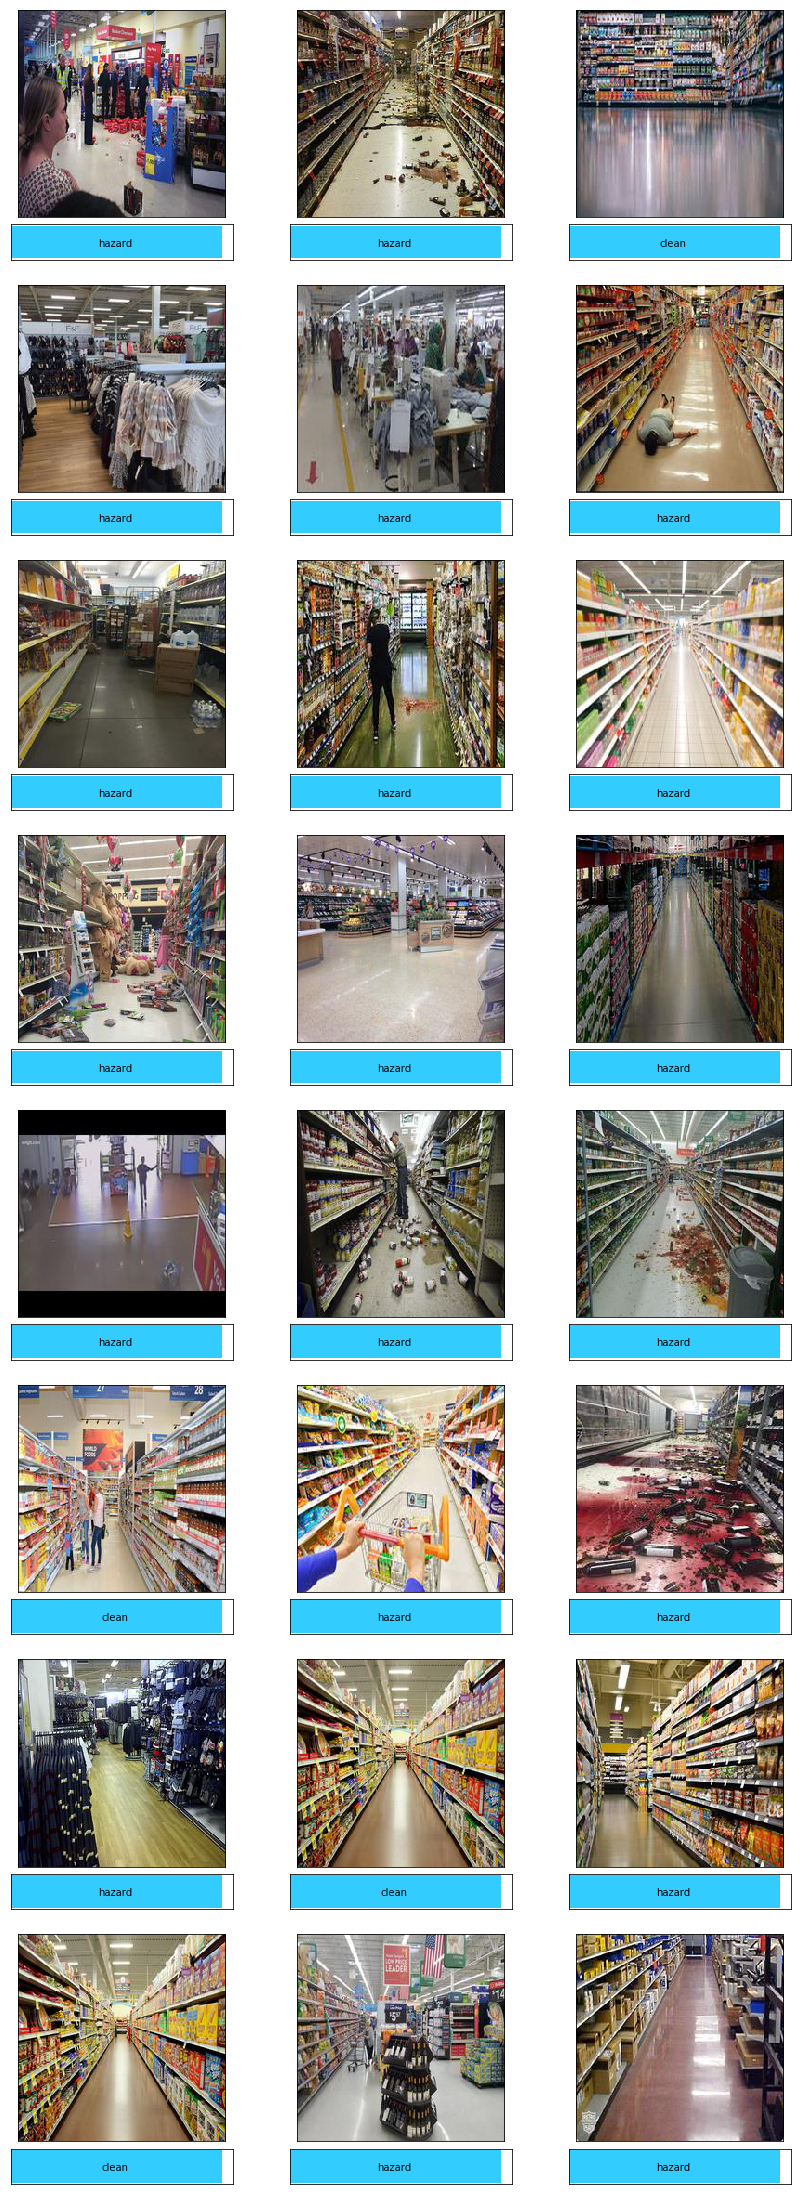

In [60]:
plot_predictions(caltech101_images_test, result, categories, TOP_P)

In [42]:
import os
import subprocess
import time
import cv2
import psutil

#path = os.getcwd()
path = '/home/murshed/phd/git_research/mldledge/tensorflow/fine-tuneUsingtf/edgetpu/hazard_data/testdata_onCoral/sdir/'
script_path = '/usr/lib/python3/dist-packages/edgetpu/demo/'
#folders = []

files = os.listdir(path)
#print (files)

images = {}
false_assum = {}

for file in files:
   if 'hazard' in file:
      images.update({file : 'hazard'})
   elif 'clean' in file:
      images.update({file : 'clean'})

#print (images)

total_time = 0
for key in images:
   print ('\n\nImage name : ',key, 'Tag: ' , images[key], 'floor and the classification result is : ' )
   
   img = cv2.imread(path+key)
   img = cv2.resize(img,(224,224))
   #img = np.reshape(img,[1,224,224,3])
   #image = tf.cast(img, tf.float32)
   image = transform(img)
   start_time = time.time()
   classes = net(image)
   total_time = total_time + (time.time()-start_time)
   print(classes)
   pid = os.getpid()
   py = psutil.Process(pid)
   memoryUse = py.memory_info()[0]/2.**30  # memory use in GB...I think
   cpuusage = py.cpu_percent()
   print('memory use:', memoryUse)
   print('cpu use:', cpuusage)
   if classes[0][0] > classes[0][1]:
        res = 'clean'
        print('clean')
   else:
        res = 'hazard'
        print('hazard')
   
#    print("---%s seconds ---" % (time.time() - start_time))
   print("Image Name", key ,"classify as : ", res )
   if images[key] in res:
      images[key] = 1
   else:
      images[key] = 0
      false_assum.update({key: 0})
print("Total avg inference time: ", total_time/138)

print ("List of wrong assumtion : ", false_assum)
print ('########## Final result #########')
print ('Total right assumtion : ', sum(images.values()), '\nTotal worng assumtion : ', len(images)-sum(images.values()), '\nModel accuracy = ', round((sum(images.values())*100)/len(images), 3), '%')



Image name :  clean_62.jpg Tag:  clean floor and the classification result is : 

[[0.88569903 1.1007864 ]]
<NDArray 1x2 @gpu(0)>
memory use: 4.477531433105469
cpu use: 0.0
hazard
Image Name clean_62.jpg classify as :  hazard


Image name :  clean_53.jpg Tag:  clean floor and the classification result is : 

[[ 1.4153746  -0.49872696]]
<NDArray 1x2 @gpu(0)>
memory use: 4.477531433105469
cpu use: 0.0
clean
Image Name clean_53.jpg classify as :  clean


Image name :  clean_29.jpg Tag:  clean floor and the classification result is : 

[[-0.15057492  0.10666896]]
<NDArray 1x2 @gpu(0)>
memory use: 4.477531433105469
cpu use: 0.0
hazard
Image Name clean_29.jpg classify as :  hazard


Image name :  hazard_44.jpg Tag:  hazard floor and the classification result is : 

[[-0.664996   4.6963134]]
<NDArray 1x2 @gpu(0)>
memory use: 4.477531433105469
cpu use: 0.0
hazard
Image Name hazard_44.jpg classify as :  hazard


Image name :  hazard_3.jpg Tag:  hazard floor and the classification result is : 


[[-0.90765697  1.9146997 ]]
<NDArray 1x2 @gpu(0)>
memory use: 4.477588653564453
cpu use: 0.0
hazard
Image Name hazard_50.jpg classify as :  hazard


Image name :  hazard_43.jpg Tag:  hazard floor and the classification result is : 

[[-0.4815874  3.4198034]]
<NDArray 1x2 @gpu(0)>
memory use: 4.477588653564453
cpu use: 0.0
hazard
Image Name hazard_43.jpg classify as :  hazard


Image name :  clean_25.jpg Tag:  clean floor and the classification result is : 

[[ 3.5965412  -0.58157516]]
<NDArray 1x2 @gpu(0)>
memory use: 4.477588653564453
cpu use: 0.0
clean
Image Name clean_25.jpg classify as :  clean


Image name :  hazard_13.jpg Tag:  hazard floor and the classification result is : 

[[0.22481823 2.454369  ]]
<NDArray 1x2 @gpu(0)>
memory use: 4.477588653564453
cpu use: 0.0
hazard
Image Name hazard_13.jpg classify as :  hazard


Image name :  clean_8.jpg Tag:  clean floor and the classification result is : 

[[-1.1062833  2.1445448]]
<NDArray 1x2 @gpu(0)>
memory use: 4.477588653564453
c


[[-1.4355147  3.2564385]]
<NDArray 1x2 @gpu(0)>
memory use: 4.477977752685547
cpu use: 0.0
hazard
Image Name hazard_51.jpg classify as :  hazard


Image name :  hazard_27.jpg Tag:  hazard floor and the classification result is : 

[[0.15134317 4.6902914 ]]
<NDArray 1x2 @gpu(0)>
memory use: 4.477977752685547
cpu use: 0.0
hazard
Image Name hazard_27.jpg classify as :  hazard


Image name :  hazard_15.jpg Tag:  hazard floor and the classification result is : 

[[-0.7357614  4.8278766]]
<NDArray 1x2 @gpu(0)>
memory use: 4.477977752685547
cpu use: 0.0
hazard
Image Name hazard_15.jpg classify as :  hazard


Image name :  clean_70.jpg Tag:  clean floor and the classification result is : 

[[ 1.546292  -0.2847321]]
<NDArray 1x2 @gpu(0)>
memory use: 4.477977752685547
cpu use: 0.0
clean
Image Name clean_70.jpg classify as :  clean


Image name :  hazard_11.jpg Tag:  hazard floor and the classification result is : 

[[-1.7004219  5.4321294]]
<NDArray 1x2 @gpu(0)>
memory use: 4.477977752685547
cp